In [1]:
#ee version 0.1.221
##geemap version 0.6.13

In [2]:
import ee
import geemap
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [4]:
print(ee.__version__)
print(geemap.__version__)
ee.Initialize()

0.1.235
0.7.13


In [5]:
manaus_shp = '/home/jbk/projects/climate/tropics/venus/footprints/venus_fgmanaus_footprint/venus_fgmanaus_footprint.shp'
manaus = geemap.shp_to_ee(manaus_shp)
info = manaus.geometry()
manaus = ee.Geometry(info)

atto_shp = '/home/jbk/projects/climate/tropics/venus/footprints/venus_atto_footprint/venus_atto_footprint.shp'
atto = geemap.shp_to_ee(atto_shp)
info = atto.geometry()
atto = ee.Geometry(info)

corumba_shp = '/home/jbk/projects/climate/tropics/venus/footprints/venus_corumba_footprint/venus_corumba_footprint.shp'
corumba = geemap.shp_to_ee(corumba_shp)
info = corumba.geometry()
corumba = ee.Geometry(info)

mato_shp = '/home/jbk/projects/climate/tropics/venus/footprints/venus_mato_footprint/venus_mato_footprint.shp'
mato = geemap.shp_to_ee(mato_shp)
info = mato.geometry()
mato = ee.Geometry(info)

saop_shp = '/home/jbk/projects/climate/tropics/venus/footprints/venus_saop_footprint/venus_saop_footprint.shp'
saop = geemap.shp_to_ee(saop_shp)
info = saop.geometry()
saop = ee.Geometry(info)

In [6]:
#Select geom of interest to export
fc = manaus

In [7]:
#Calculate NDRE and set palette
def addNDRE(image):
    ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')
    return image.addBands(ndre)

In [8]:
#Create cloud mask
cloudBitMask = ee.Number(2).pow(10).int() #bit 10 is clouds
cirrusBitMask = ee.Number(2).pow(11).int() #bit 11 is cirrus clouds
def maskS2clouds(image):
    qa = image.select('QA60')
    # Both flags should be set to zero, indicating clear conditions.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1<< 11
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0)))
    return image.updateMask(mask)

In [9]:
#Load sentinel-2 data
s2 = (ee.ImageCollection('COPERNICUS/S2')#Select S2 1-C level data
      .select(['B5', 'B8', 'QA60']) #Select necessary bands to reduce memory usage
      .filterBounds(fc) #Narrow data spatially
      .filterDate(ee.Date('2016-01-01'), ee.Date('2019-12-31')) #Select years of interest
      .sort('CLOUDY_PIXEL_PERCENTAGE', False) #Put smallest %cloud image on top of stack
      .map(addNDRE)) #calculate NDRE and add as band

In [10]:
#Create collection with cloud mask
col = s2.map(maskS2clouds)

In [11]:
#15-day step
years = ee.List.sequence(2017, 2019)
step = ee.List.sequence(1, 365, 15)

def byYear(y):
    y = ee.Number(y)
    def byStep(d):
        d = ee.Number(d)
        return (col
                .filter(ee.Filter.calendarRange(y, y, 'year')) #yearly step
                .filter(ee.Filter.calendarRange(d, d.add(14), 'day_of_year')) #15-day step
#                .max()
                .qualityMosaic('NDRE') #Max greenness
                .set('step', [d, y])) #Add properties
    return step.map(byStep)

col = ee.ImageCollection.fromImages(years.map(byYear).flatten())
col = col.map(lambda image: image.clip(fc)).select('NDRE')

In [ ]:
print(col.getInfo())

##ONLY RUN THIS BLOCK FOR ATTO, OTHERWISE SKIP##
#Atto removal: 5, 24
col = (col.filter(ee.Filter.neq('step', [76, 2016])) #5
       .filter(ee.Filter.neq('step', [361, 2016]))) #24

##ONLY RUN THIS BLOCK FOR SAOP, OTHERWISE SKIP##
#Saop removal: 9, 24, 99
col = (col.filter(ee.Filter.neq('step', [361, 2019])) #99
       .filter(ee.Filter.neq('step', [361, 2016])) #24
       .filter(ee.Filter.neq('step', [136, 2016]))) #9

In [ ]:
#Export images from a collection
out_dir = '/home/jbk/projects/climate/tropics/sentinel-2/15day_composites/manaus/'
geemap.ee_export_image_collection(col, out_dir, region = fc, scale = 20, file_per_band=False)

## Monthly composites

In [ ]:
mcol = s2.map(maskS2clouds)

#Monthly step
#https://gis.stackexchange.com/questions/301165/how-to-get-monthly-averages-from-earth-engine-in-the-python-api
months = ee.List.sequence(1, 12) #Create a list with nums 1-12
years = ee.List.sequence(2016, 2016)

def byYear(y):
    def byMonth(m):
        return (mcol
                .filter(ee.Filter.calendarRange(y, y, 'year'))
                .filter(ee.Filter.calendarRange(m, m, 'month'))
                .qualityMosaic('NDRE') #What is best way to compile images before running stats?
                .set('month', m).set('year', y))
    return months.map(byMonth)

mcol = ee.ImageCollection.fromImages(years.map(byYear).flatten())
mcol = mcol.map(lambda image: image.clip(fc)).select('NDRE') #Choose JUST NDRE band and clip to region

In [ ]:
#Export images from a collection
out_dir = '/home/jbk/projects/climate/tropics/sentinel-2/monthly_composites/manaus/qm/'
geemap.ee_export_image_collection(mcol, out_dir, region = fc, scale = 20, file_per_band=False)

## Visualize Map

In [ ]:
Map = geemap.Map(center = (-2.609097222, -60.20929722), zoom = 10)
brma2_point = ee.Geometry.Point(-60.20929722, -2.609097222)
brma2_region = ee.Geometry.Rectangle(-61.00, -3.0, -60.00, -2.0)
Map
#Map.addLayer(brma2_region, {}, 'Manauas Region')

In [ ]:
#Load sentinel-2 data
s2 = (ee.ImageCollection('COPERNICUS/S2')#Select S2 1-C level data
#      .select(['B5', 'B8', 'QA60']) #Select necessary bands to reduce memory usage
      .filterBounds(fc) #Narrow data spatially
      .filterDate(ee.Date('2017-01-01'), ee.Date('2017-01-15')) #Select years of interest
      .sort('CLOUDY_PIXEL_PERCENTAGE', False) #Put smallest %cloud image on top of stack
      .map(addNDRE)) #calculate NDRE and add as band

In [ ]:
print(s2.size().getInfo())

In [ ]:
maxval = s2.max()

visParams = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
}

Map.addLayer(maxval, visParams, 'MaxVal')
#Map.addLayer(s2, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'RGB Manaus Clouds')

In [ ]:
maxndre = s2.qualityMosaic('NDRE')
print(maxndre.getInfo())

In [ ]:
#maxndre = s2.median()
palette = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850']
Map.addLayer(maxndre.select('NDRE'), {'palette': palette}, 'NDRE')

In [ ]:
#Export images from a collection
out_dir = '/home/jbk/projects/climate/tropics/sentinel-2/monthly_composites/manaus/qm/'
geemap.ee_export_image_collection(mcol, out_dir, region = fc, scale = 20, file_per_band=False)

## Time series plots

In [12]:
# Mean
def region_mean_Image(img):
    # mean over all pixels in the region for the image
    return img.set('mean', img.reduceRegion(ee.Reducer.mean(), geometry=fc, scale=20)) 


def region_mean_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_mean_Image)
    stats_list = stats.aggregate_array('mean')
    return np.array(stats_list.getInfo())

# Median
def region_median_Image(img):
    # mean over all pixels in the region for the image
    return img.set('median', img.reduceRegion(ee.Reducer.median(), geometry=fc, scale=20)) 

def region_median_ImageCollection(ic):
    # mean over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_median_Image)
    stats_list = stats.aggregate_array('median')
    return np.array(stats_list.getInfo())

# Stddev
def region_stddev_Image(img):
    # stddev over all pixels in the region for the image
    return img.set('stddev', img.reduceRegion(ee.Reducer.stdDev(), geometry=fc, scale=20)) 

def region_stddev_ImageCollection(ic):
    # stddev over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_stddev_Image)
    stats_list = stats.aggregate_array('stddev')
    return np.array(stats_list.getInfo())

# Percentiles
def region_percentiles_Image(img):
    # 5,10,25,75,90,95 percentiles over all pixels in the region for the image
    return img.set('percentiles', img.reduceRegion(ee.Reducer.percentile([5,10,25,75,90,95]), geometry=fc, scale=20)) #) mean, median, stdDev, percentiles

def region_percentiles_ImageCollection(ic):
    # percentiles over all pixels in the region, for each image in the ImageCollection
    stats = ic.map(region_percentiles_Image)
    stats_list = stats.aggregate_array('percentiles')
    return np.array(stats_list.getInfo())


In [13]:
#Take only the ndre mean, med, stddev dict values and append to new list
def newList(alist, varname):
    list_name = []
    for value in alist:
        list_name.append(value[varname])
    return list_name

In [14]:
#Append ndre percentile dict values to new lists
def p_list(alist, varname):
    p10, p25, p5, p75, p90, p95 = [], [], [], [], [], []
    for value in alist:
        p5.append(value[varname+'_p5'])
        p10.append(value[varname+'_p10'])
        p25.append(value[varname+'_p25'])
        p75.append(value[varname+'_p75'])
        p90.append(value[varname+'_p90'])
        p95.append(value[varname+'_p95'])
    return p5, p10, p25, p75, p90, p95

In [15]:
# total precipitation
# get area statistics
col_mean_list = region_mean_ImageCollection(col)
col_median_list = region_median_ImageCollection(col)
col_stddev_list = region_stddev_ImageCollection(col)
col_percentile_list = region_percentiles_ImageCollection(col)

# turn it into numpy array
col_mean = newList(col_mean_list, 'NDRE')
col_median = newList(col_median_list, 'NDRE')
col_stddev = newList(col_stddev_list, 'NDRE')
col_percentile = p_list(col_percentile_list, 'NDRE')


In [18]:
# get list of dates from ImageCollection
def ymdList(imgcol):
    def iter_func(image, newlist):
        date = ee.Number.parse(image.date().format("YYYYMMdd"));
        newlist = ee.List(newlist);
        return ee.List(newlist.add(date).sort())
    ymd = imgcol.iterate(iter_func, ee.List([]))
    return list(ee.List(ymd).reduce(ee.Reducer.frequencyHistogram()).getInfo().keys())

In [19]:
icdates = ymdList(col)

EEException: Image.date: Image '0' does not have a 'system:time_start' property.

In [16]:
def plot_mean_stddev(var_mean, var_stddev, var_name):
    #Make lists with +/- SD
    months=np.array(list(range(0,25*3)))
    plus_error = [x + y for x,y in zip(var_mean, var_stddev)]
    minus_error = [x - y for x,y in zip(var_mean, var_stddev)]

    plt.axes([2, 0, 2, 1])
    plt.grid(b = True, which = 'major', axis = 'x')
    plt.fill_between(months, plus_error, minus_error, color = "grey", alpha = .5, label = "Standard Deviation")
    plt.plot(months, var_mean, label=var_name)
    plt.legend(loc = "upper right")

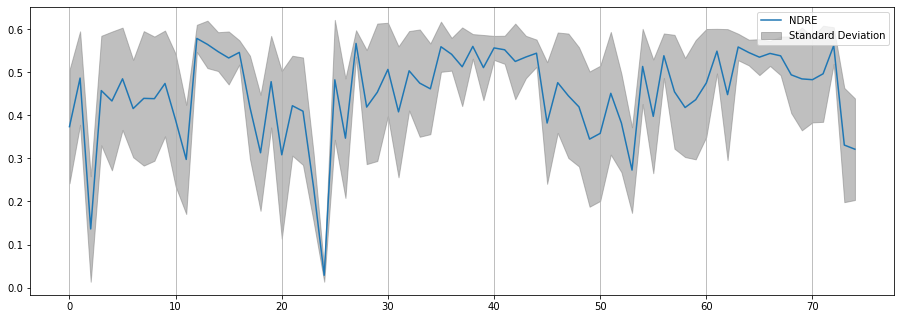

In [17]:
plot_mean_stddev(col_mean, col_stddev, var_name="NDRE")

In [ ]:
plot_mean_stddev(col_mean, col_stddev, var_name="NDRE")